In [29]:
import psycopg2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [30]:
from src.load_review_data import ReviewDataLoader
rdl = ReviewDataLoader()
df = rdl.retrieve_all_reviews()
#df = rdl.retrieve_reviews('LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model)')
df.head(2)

,id,product,url,p_no,r_no,r_stars,r_date,r_name,r_title,r_text,r_comments,brand_name,category,model,rating,reviews
0,6897,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-55UJ6300...,14,134,4.0 out of 5 stars,"February 10, 2018",Richard Monigold,Four Stars,nice tv,Verified Purchase Helpful No...,LG,tv,55UJ6300,4,Four Stars nice tv
1,6898,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-55UJ6300...,14,135,5.0 out of 5 stars,"May 15, 2018",Amazon Customer,Five Stars,Love it,Verified Purchase Helpful No...,LG,tv,55UJ6300,5,Five Stars Love it


In [31]:
df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','4.0 out of 5 stars','2.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x in ['4.0 out of 5 stars','5.0 out of 5 stars'] else 0)
df_new['reviews'] = df['r_title'] + ' ' + df['r_text']
df_new['review_length'] = df['r_text'].apply(lambda x: len(x))
df_new = df_new[['rating','product','reviews','model','review_length']]
df_new = df_new[df_new['review_length'] < 1000]
df_new = df_new[df_new['review_length'] > 10]
df_new.head(2)

,rating,product,reviews,model,review_length
3,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,Five Stars Great Value,55UJ6300,11
7,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,"Four Stars Very nice to, Im satisfied.",55UJ6300,27


In [32]:
df_new.count()

rating           7073
product          7073
reviews          7073
model            7073
review_length    7073
dtype: int64

In [56]:
from src.Trigrams import Trigrams
tr = Trigrams()
tr.build_trigrams2(df_new)

In [57]:
df_trigrams = tr.df_prod[['rating','product','review_trigrams','model','review_length']]
df_trigrams = df_trigrams.rename(columns={'review_trigrams':'reviews'})
df_trigrams.head(2)

,rating,product,reviews,model,review_length
3,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,great value,55UJ6300,11
7,1,LG Electronics 55UJ6300 55-Inch 4K Ultra HD Sm...,satisfied,55UJ6300,27


In [58]:
from src.naive_review_analyzer import NaiveReviewAnalyzer
from src.LdaReviewAnalyzer import LdaReviewAnalyzer

In [59]:
nra = NaiveReviewAnalyzer()


In [60]:
df_test = df_trigrams[df_trigrams['model'] == '65UJ6300']
df_test.groupby('rating').count()

,product,reviews,model,review_length
rating,,,,
0,64,64,64,64
1,254,254,254,254


In [61]:
total_count = df_test['rating'].count()
df_neg = df_test[df_test['rating'].apply(lambda x: x in [1,2])]
neg_count = df_neg['rating'].count()
df_pos = df_test[df_test['rating'].apply(lambda x: x in [4,5])]
pos_count = df_pos['rating'].count()
nra.create_bow(df_test)
neg_nouns,neg_adjs  = nra.create_word_list(rating=[0])
pos_nouns, pos_adjs = nra.create_word_list(rating=[1])

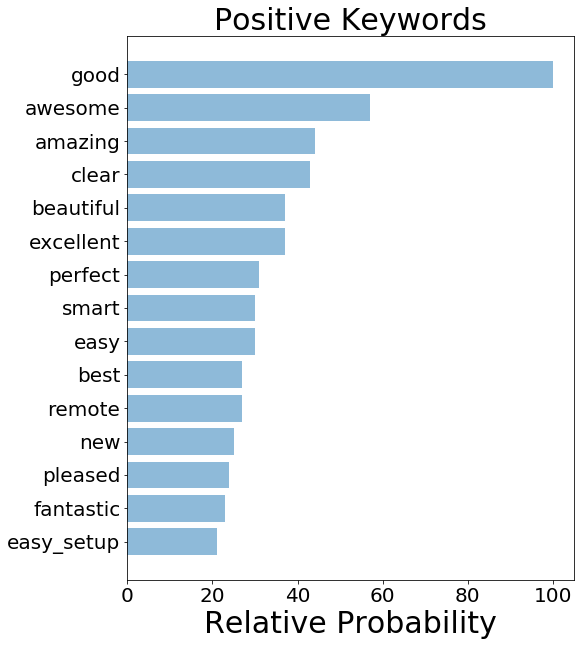

In [54]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
max_count = 15    
objects = [x[0] for i,x in enumerate(pos_adjs) if i < max_count]
#y_pos = list(range(len(objects)))
y_pos = list(range(len(objects)-1,-1,-1))
performance = [x[1] for i,x in enumerate(pos_adjs) if i < max_count]
    
fig, ax = plt.subplots(1,1, figsize=(8,10))
ax.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects, fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel('Relative Probability', fontsize=30)
ax.set_title('Positive Keywords', fontsize=30)
 
plt.show()

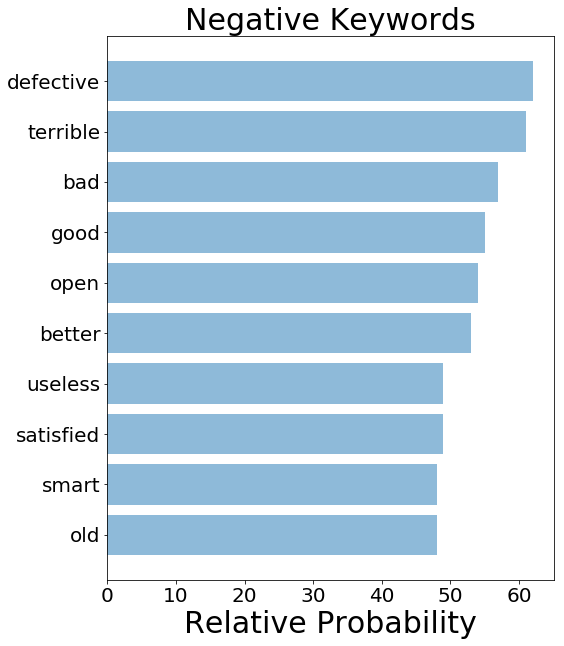

In [62]:
max_count = 15    
objects = [x[0] for i,x in enumerate(neg_adjs) if i < max_count]
#y_pos = list(range(len(objects)))
y_neg = list(range(len(objects)-1,-1,-1))
performance = [x[1] for i,x in enumerate(neg_adjs) if i < max_count]
    
fig, ax = plt.subplots(1,1, figsize=(8,10))
ax.barh(y_neg, performance, align='center', alpha=0.5)
plt.yticks(y_neg, objects, fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel('Relative Probability', fontsize=30)
ax.set_title('Negative Keywords', fontsize=30)
 
plt.show()